## Overview

A few days ago I made a naive classification baseline which treated every class equally. The result was not that terrible compared to the other kernels of the same idea, however if you look at the leaderboard right now you can clearly see there is something I missed.

So beside that, there are two other rather obvious approaches:

- One/few-shot detection, this was nicely demonstrated by **@martinpiotte** in the playground competition, so we can be sure that it works: https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563. However trying to fit this into a kernel seems to be hard work. (I'll try again in the weekend?)

- The other one is more simple, we remove class 0 (**new_whale**) from the training set and train a classifier on the rest. At inference, we try to find a threshold value to decide whether and where to insert **new_whale** to the final predictions.

For example, suppose that the top 5 predictions are [class1, class2, class3, class4, class5] which have confidence values of [0.8, 0.05, 0.02, 0.02, 0.01] and the threshold found with the validation set was 0.3, then the predictions become: [class1, new_whale, class2, class3, class4]

## Training 

Let's start by importing our libararies.

In [4]:
# from fastai.conv_learner import *
# from fastai.dataset import *
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
import math

In [2]:
MODEL_PATH = 'Resnet18_v1'
TRAIN = 'train/'
TEST = 'test/'
LABELS = 'train.csv'
SAMPLE_SUB = 'sample_submission.csv'


The architecture is flexible, I chose Resnet18 since it can fit quite well into a kernel. You may play with this if you want to. 

In [ ]:
arch = resnet34
nw = 4

Next, we prapare out dataset to work with Fastai's pipeline.

In [5]:
df = pd.read_csv(LABELS).set_index('Image')
new_whale_df = df[df.Id == "new_whale"] # only new_whale dataset
train_df = df[~(df.Id == "new_whale")] # no new_whale dataset, used for training
unique_labels = np.unique(train_df.Id.values)

labels_dict = dict()
labels_list = []
for i in range(len(unique_labels)):
    labels_dict[unique_labels[i]] = i
    labels_list.append(unique_labels[i])
print("Number of classes: {}".format(len(unique_labels)))
train_names = train_df.index.values
train_df.Id = train_df.Id.apply(lambda x: labels_dict[x])
train_labels = np.asarray(train_df.Id.values)
test_names = [f for f in os.listdir(TEST)]

Number of classes: 5004


c:\python\python36\lib\site-packages\pandas\core\generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Let's draw a simple histogram to see the sample-per-class distribution.

711     73
3028    65
3048    62
63      61
2174    57
1210    54
1664    51
4951    50
2647    49
858     48
4121    47
4712    45
2353    45
1833    40
2341    40
1039    40
3277    37
1868    37
1751    37
1991    36
3396    35
4844    34
577     34
484     33
4178    32
163     31
2712    31
2097    31
4955    30
1576    30
        ..
2874     1
819      1
2270     1
4913     1
2858     1
2278     1
803      1
4897     1
4333     1
2930     1
4985     1
2938     1
2994     1
183      1
1003     1
3050     1
995      1
987      1
3034     1
191      1
939      1
4993     1
2986     1
931      1
199      1
923      1
915      1
2954     1
5001     1
0        1
Name: Id, Length: 5004, dtype: int64

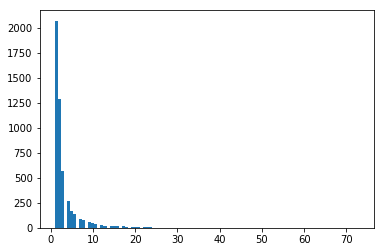

In [6]:
labels_count = train_df.Id.value_counts()
_, _,_ = plt.hist(labels_count,bins=100)
labels_count

In [7]:
dup = []
for idx,row in train_df.iterrows():
    if labels_count[row['Id']] < 5:
        dup.extend([idx]*math.ceil((5 - labels_count[row['Id']])/labels_count[row['Id']]))      

In [8]:
dup

['0001f9222.jpg',
 '00029d126.jpg',
 '001c1ac5f.jpg',
 '001c1ac5f.jpg',
 '00357e37a.jpg',
 '00357e37a.jpg',
 '004775679.jpg',
 '0050ef29d.jpg',
 '0050ef29d.jpg',
 '00514c876.jpg',
 '00514c876.jpg',
 '0073118da.jpg',
 '0073118da.jpg',
 '007a7846f.jpg',
 '007b62e05.jpg',
 '008124524.jpg',
 '008124524.jpg',
 '0084fe40b.jpg',
 '008ebc50d.jpg',
 '009431af0.jpg',
 '009431af0.jpg',
 '00961802f.jpg',
 '00a3dd76f.jpg',
 '00a3dd76f.jpg',
 '00a4de95e.jpg',
 '00a4de95e.jpg',
 '00a4de95e.jpg',
 '00a4de95e.jpg',
 '00b92e9bf.jpg',
 '00b92e9bf.jpg',
 '00bc4dade.jpg',
 '00cf9982e.jpg',
 '00cf9982e.jpg',
 '00d43f154.jpg',
 '00d9e8278.jpg',
 '00d9e8278.jpg',
 '00e68dc59.jpg',
 '00e68dc59.jpg',
 '00e68dc59.jpg',
 '00e68dc59.jpg',
 '00eaedfab.jpg',
 '00f0bde81.jpg',
 '010262224.jpg',
 '01070510c.jpg',
 '01070510c.jpg',
 '011258703.jpg',
 '011258703.jpg',
 '011258703.jpg',
 '011258703.jpg',
 '0118a64b8.jpg',
 '0118a64b8.jpg',
 '0118a64b8.jpg',
 '0118a64b8.jpg',
 '0124d2989.jpg',
 '0124d2989.jpg',
 '0139248b

In [9]:
train_names = np.concatenate([train_names, dup])
train_names = train_names[np.random.RandomState(seed=42).permutation(train_names.shape[0])]
len(train_names)

31925

In [11]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42069)
for train_idx, val_idx in sss.split(train_names, np.zeros(train_names.shape)):
    tr_n, val_n = train_names[train_idx], train_names[val_idx]
print(len(tr_n), len(val_n))

25540 6385


The image sizes seem to vary, so we'll try to see what the average width and height are:

In [ ]:
avg_width = 0
avg_height = 0
for fn in os.listdir(TRAIN)[:1000]:
    img = cv2.imread(os.path.join(TRAIN,fn))
    avg_width += img.shape[1]
    avg_height += img.shape[0]
avg_width //= 1000
avg_height //= 1000
print(avg_width, avg_height)

They turn out to be quite big, especially the width, so below you'll see I resize everything back to **384**. You may consider continue training on bigger size, but that probably won't fit in a kernel. 

In [ ]:
class HWIDataset(FilesDataset):
    def __init__(self, fnames, path, transform):
        self.train_df = train_df
        super().__init__(fnames, transform, path)

    def get_x(self, i):
        img = open_image(os.path.join(self.path, self.fnames[i]))
        # We crop the center of the original image for faster training time
        img = cv2.resize(img, (self.sz, self.sz))
        return img

    def get_y(self, i):
        if (self.path == TEST): return 0
        return self.train_df.loc[self.fnames[i]]['Id']


    def get_c(self):
        return len(unique_labels)


In [ ]:
class RandomLighting(Transform):
    def __init__(self, b, c, tfm_y=TfmType.NO):
        super().__init__(tfm_y)
        self.b, self.c = b, c

    def set_state(self):
        self.store.b_rand = rand0(self.b)
        self.store.c_rand = rand0(self.c)

    def do_transform(self, x, is_y):
        if is_y and self.tfm_y != TfmType.PIXEL: return x  # add this line to fix the bug
        b = self.store.b_rand
        c = self.store.c_rand
        c = -1 / (c - 1) if c < 0 else c + 1
        x = lighting(x, b, c)
        return x
    
def get_data(sz, bs, test_names=test_names, test_dir=TEST):
    aug_tfms = [RandomRotateZoom(deg=20, zoom=2, stretch=1),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.NO),
                RandomBlur(blur_strengths=3,tfm_y=TfmType.NO),
                RandomFlip(tfm_y=TfmType.NO)]
    tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.NO,
                           aug_tfms=aug_tfms)
    ds = ImageData.get_ds(HWIDataset, (tr_n[:-(len(tr_n) % bs)], TRAIN),
                          (val_n, TRAIN), tfms, test=(test_names, test_dir))
    md = ImageData("./", ds, bs, num_workers=nw, classes=None)
    return md


In [ ]:
# sz = (avg_width//2, avg_height//2)
batch_size = 64
md = get_data(384, batch_size)
learn = ConvLearner.pretrained(arch, md) 
learn.opt_fn = optim.Adam

Uncomment these lines to run Fastai's automatic learning rate finder. 


In [ ]:
# learn.lr_find()
# learn.sched.plot()
lr = 5e-3

We start by training only the newly initialized weights, then unfreeze the model and finetune the pretrained weights with reduced learning rate.

In [ ]:
learn.fit(lr, 2, cycle_len=3)
learn.unfreeze()
lrs = np.array([lr/10, lr/20, lr/40])
learn.fit(lrs, 4, cycle_len=4, use_clr=(20, 16))
learn.save(MODEL_PATH)

## Choosing a threshold

The validation set now contains two subset.
First, we evaluate the model on the new whale-free validation set

In [ ]:
preds_v,y_v = learn.TTA(is_test=False,n_aug=2)
preds_v = np.stack(preds_v, axis=-1)
preds_v = np.exp(preds_v)
preds_v = preds_v.mean(axis=-1)
y_v += 1

In [ ]:
preds_v_max = np.max(preds_v,axis=1)
_,_,_ = plt.hist(preds_v_max)

And then on the all-whale set that we left out at the beginning

In [ ]:
TEST=TRAIN # sorry
total_new_whale = len(new_whale_df.index.values)
md = get_data(384, batch_size, test_names=new_whale_df.index.values[:int(total_new_whale*0.2)], test_dir=TRAIN)
learn.set_data(md)
preds_w,y_w = learn.TTA(is_test=True,n_aug=2)
preds_w = np.stack(preds_w, axis=-1)
preds_w = np.exp(preds_w)
preds_w = preds_w.mean(axis=-1)

In [ ]:
preds_w_max = np.max(preds_w,axis=1)
_,_,_ = plt.hist(preds_w_max)

In [ ]:
y = np.concatenate([y_v,y_w])
preds = np.concatenate([preds_v, preds_w],axis=0)
preds = np.concatenate([np.zeros((preds.shape[0],1)), preds],axis=1)

Trying to choose the right threshold to maximize MAP@5 score

In [ ]:
def map5(X, y):
    score = 0
    for i in range(X.shape[0]):
        pred = X[i].argsort()[-5:][::-1]
        for j in range(pred.shape[0]):
            if pred[j] == y[i]:
                score += (5 - j)/5
                break
    return score/X.shape[0]

best_th = 0
best_score = 0
for th in np.arange(0.1, 0.801, 0.01):
    preds[:,0] = th
    score = map5(preds, y)
    if score > best_score:
        best_score = score
        best_th = th
    print("Threshold = {:.3f}, MAP5 = {:.3f}".format(th,score))


## Prediction

In [ ]:
TEST = '../input/test/'
md = get_data(384, batch_size, test_names=test_names, test_dir=TEST)
learn.set_data(md)
preds_t,y_t = learn.TTA(is_test=True,n_aug=8)
preds_t = np.stack(preds_t, axis=-1)
preds_t = np.exp(preds_t)
preds_t = preds_t.mean(axis=-1)
preds_t = np.concatenate([np.zeros((preds_t.shape[0],1))+best_th, preds_t],axis=1)

Finally, our submission.

In [ ]:
sample_df = pd.read_csv(SAMPLE_SUB)
sample_list = list(sample_df.Image)
labels_list = ["new_whale"]+labels_list
pred_list = [[labels_list[i] for i in p.argsort()[-5:][::-1]] for p in preds_t]
pred_dic = dict((key, value) for (key, value) in zip(learn.data.test_ds.fnames,pred_list))
pred_list_cor = [' '.join(pred_dic[id]) for id in sample_list]
df = pd.DataFrame({'Image':sample_list,'Id': pred_list_cor})
df.to_csv('submission.csv'.format(MODEL_PATH), header=True, index=False)
df.head()